# Preprocessing Audio Files and Automated Labeling of Click-Events 
## (for the Ethernet and HVA 630 connectors)


In [1]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

Important Notes:

- This nootbook is for atomated labeling of audio files, where click-events can be detected based on maximal amplitude values. This means that during the recording of the audio files, there is no other acoustic events in the surroundings that causes a higher sound intensity level than the connector click-event.

- This notebook is designed for connector types with only one click-event during their locking procedusre, such as the Ethernet and HVA 630 connectors. The notebook was tested for these two specific connector types. The HVA 280 connetor - the third connector type used in the research project - has two click-events during the full insertion process of the plug into the connetor socket, resulting in longer time intervall of interest for detection. For preprocessing and labeling the audio files of the HVA 280 connetor, the notebook "preprocessTwoClickAudio.ipynb" is used.

In [21]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing ## modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting ## modul for mel-spectrogram visualization
import sharedValues ## modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
#processAudio = processAudio()
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()


## 1. Read in audio files, process audio data, and generate mel-scaled spectrograms

In [3]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [23]:
# select dataset (from datasets recorded without additional noise)
# dataset_num = 0 for Ethernet connector
# dataset_num = 4 for HVA 630 connector

dataset_num = 4
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  05_HVA630


In [24]:
# add audio files from selected dataset to a list

# sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)

print(f"Dataset length: {len(audio_files_sorted)}")

i = 0
print("First 5 files in the selected dataset:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1


Dataset length: 60
First 5 files in the selected dataset:
HVA630_1.m4a
HVA630_2.m4a
HVA630_3.m4a
HVA630_4.m4a
HVA630_5.m4a


In [25]:
# constant shared parameters (used in real-time detection as well)

sampling_rate = sharedValuesConfig.SAMPLING_RATE ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX ## maximum frequency in Hz
dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value

In [26]:
# get information about the range of values in the mel-spectrogram
# these infromation is used for the dB conversion

max_amplitude_squere_mel = None
min_amplitude_squere_mel = None

for i in range(len(audio_files_sorted)):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min = None, dB_ref = None)
    if i == 0:
        max_amplitude_squere_mel = D_mel.max()
        min_amplitude_squere_mel = D_mel.min()
    else:
        max_amplitude_squere_mel = D_mel.max() if D_mel.max() > max_amplitude_squere_mel else max_amplitude_squere_mel
        min_amplitude_squere_mel = D_mel.min() if D_mel.min() < min_amplitude_squere_mel else min_amplitude_squere_mel

print(f"Min amplitude squere in the mel-spectrograms: {min_amplitude_squere_mel}, Max amplitude squere in the mel-spectrograms: {max_amplitude_squere_mel}")

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Min amplitude squere in the mel-spectrograms: 3.327442759260696e-13, Max amplitude squere in the mel-spectrograms: 42.06034469604492


In [8]:
# constant values (used in real-time detection as well)

# dB_ref and a_squere_min is choosen based on the min and max values of amplitude squere in the dataset

dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value

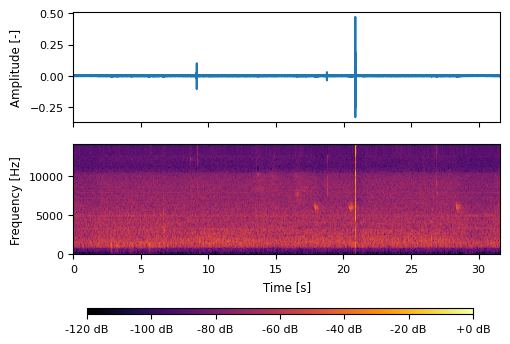

In [17]:
# plot the wave and mel spectrogram of an audio file from the selected dataset

file_id_num = 1 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

## 2. Automated labeling - find click peaks in the wave files
Note: This works only for files where click peak can be easily detected, i.e. no other noise with higher amplitude is present in the wavefrom

In [14]:
# calculating peak times for each audio file in the selected dataset based on the maximum absolute value of the signal amplitude

# calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref):
    signals = [] # audio wave forms
    signal_times = [] # time stamps in seconds for all samples in an audio file 
    peak_times = [] # in seconds, time of the peak in each signal
    spectrograms = []

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
        signals.append(signal)
        signal_times.append(time)
        spectrograms.append(D_mel_dB)

        # search abs max value of the signal within the search interval

        search_interval_min = 5 # in seconds from which the peak search starts
        search_interval_min_index = search_interval_min * sampling_rate
        search_interval_max_index = len(signal)

        j = search_interval_min_index
        peak_index = j
        while j < search_interval_max_index-1:
            if signal[j+1] > signal[peak_index]:
                peak_index = j+1
            j = j + 1
        
        peak_time = peak_index / sampling_rate
        peak_times.append(peak_time)

    return signals, signal_times, peak_times, spectrograms 

# get the signals, signal times and peak times for the selected dataset
signals, signal_times, peak_times, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref)


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


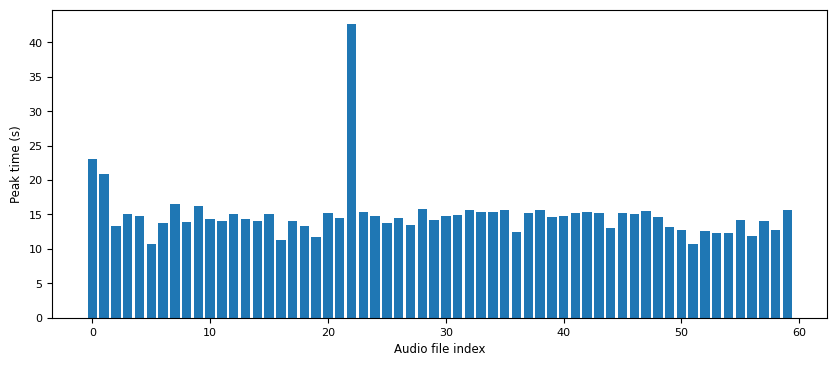

Mean of the peak times in the peg-in-hole process: 14.927367187500003


In [15]:
# check if the peak time are around the same time for all audio files -> same robotic peg-in-hole event was recorded with nearly the same start and stop times
# outliers should be checked

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times)), peak_times)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

plt.show()

print(f"Mean of the peak times in the peg-in-hole process: {np.mean(peak_times)}")

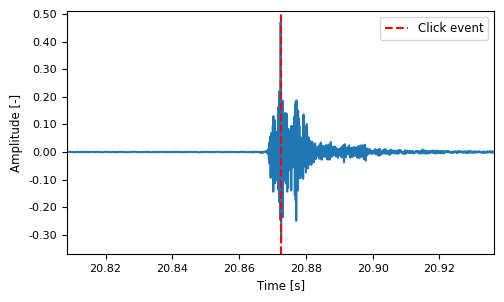

In [22]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

time_interval = (chunk_size/sampling_rate) # this will be the window size in the real time detection --> 4 chunks with 4096 samples each --> with the 32 kHz sampling rate this is 0.512 seconds

signal = signals[file_id_num]
time = signal_times[file_id_num]
peak_time = peak_times[file_id_num]
interval = time_interval/2 # for setting the x mina and max limits of the plot --> peak time +/- interval

spectrogramPlotter.plot_signal_interval(signal, time, peak_time, interval)

## 3. Go through each audio data with a sliding window and create a labeled training dataset
In the real-time detection, a time frame of 0.512 seconds will be investigated for every new chunk input at 0.128 seconds. 0.512 seconds covers 4 chunks. This chunks are stacked together and if a new chunks comes, the oldest chunk falls out from the invetigated frame.

In [ ]:
# duration is set to be larger than click events (click events around 0.015s)

window_size = sharedValuesConfig.WINDOW_SIZE # 0.512 seconds, corresponds to 4 chunks with 4096 samples each, larger than the click event duration
## -> 32 columns in the spectrogram
step_size = sharedValuesConfig.STEP_SIZE ## in this case 8, number of spectrogram columns in the step size
## corresponds 0.128 seconds --> 3/4 overlap

print(window_size, step_size)

32 8


In [30]:
# create spectrogram chunks and corresponding labels for the selected dataset

spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

def createSpectrogramDataset(spectrograms, signals, signal_times, peak_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]
        peak_time = peak_times[i]
        peak_time_index = int(peak_time / resolution)

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            if start_idx <= peak_time_index < end_idx:
                label = 1
            else:
                label = 0

            spec_chunk_dataset.append(spectrogram_chunk)
            spec_chunk_labels.append(label)
            signal_chunks.append(signal_chunk)
            time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times, peak_times)

print(len(spec_chunk_dataset)) # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels
print(spec_chunk_labels.count(1)) # number of chucnks containing click events --> because of the window overlap it is larger than the dataset length
print([i for i, x in enumerate(spec_chunk_labels) if x == 1][:10]) # indices of the chunks containing click events, first 10

print(np.min(spec_chunk_dataset))
print(np.max(spec_chunk_dataset))

15717
15717
240
[177, 178, 179, 180, 431, 432, 433, 434, 693, 694]
-120.0
-13.761271


In [31]:
# Balance the dataset 
## Reduce the number of negative samples to be 10 times the number of positive samples

np.random.seed(42)

def balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks):
    positive_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 1]
    negative_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 0]
    negative_indices_to_keep = np.random.choice(negative_indices, len(positive_indices)*10, replace=False)
    indices_to_keep = np.concatenate((positive_indices, negative_indices_to_keep))
    balanced_spec_chunk_dataset = [spec_chunk_dataset[i] for i in indices_to_keep]
    balanced_spec_chunk_labels = [spec_chunk_labels[i] for i in indices_to_keep]
    balanced_signal_chunks = [signal_chunks[i] for i in indices_to_keep]
    balanced_time_chunks = [time_chunks[i] for i in indices_to_keep]

    return balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks

balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks = balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks)

print(f"balanced chunk dataset length: {len(balanced_spec_chunk_dataset)}") # number of spectrogram chunks
print(len(balanced_spec_chunk_labels)) # number of labels
print(f"positive samples: {balanced_spec_chunk_labels.count(1)}") # number of chucnks containing click events --> because of the window overlap it is larger than the dataset length
print([i for i, x in enumerate(balanced_spec_chunk_labels) if x == 1][:10]) # indices of the chunks containing click events, first 10


print(np.min(balanced_spec_chunk_dataset))
print(np.max(balanced_spec_chunk_dataset))

balanced chunk dataset length: 2640
2640
positive samples: 240
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-120.0
-13.761271


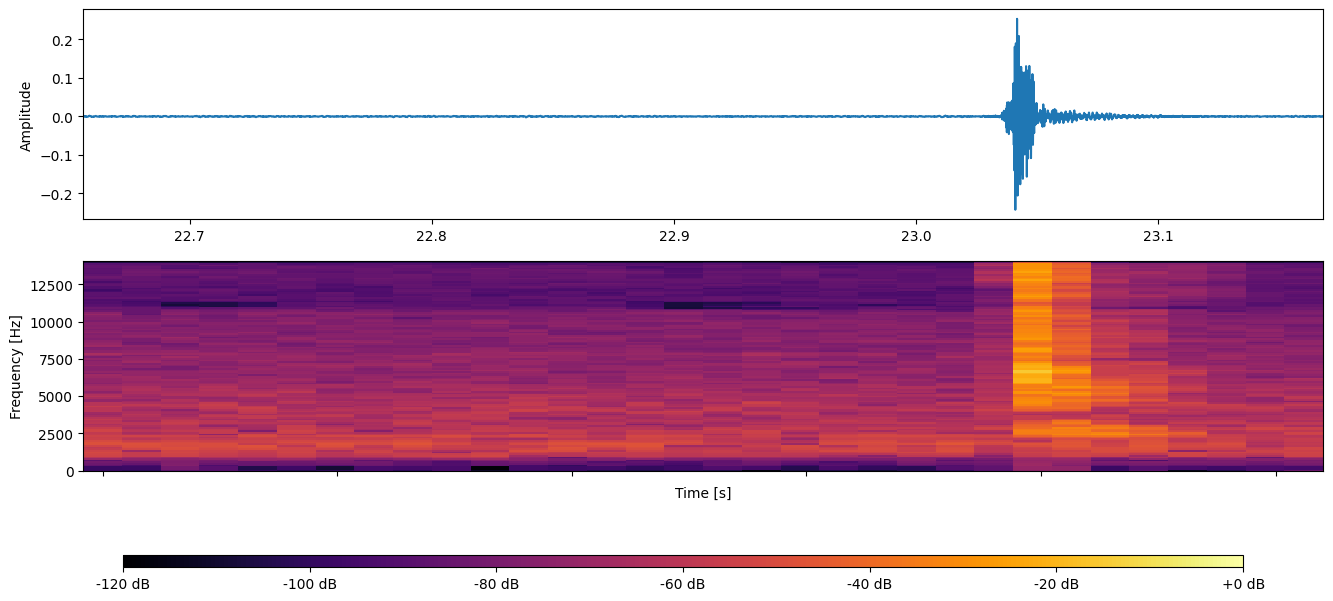

In [32]:
# plot one positive sample from the dataset

chunk_id_to_plot = 0

spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], balanced_spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)

## 4. Save the labeled dataset to the same folder as the audio files processed in .npz format

In [33]:
# save the spectrogram dataset and labels in .npz format into the same directory as the audio files

save_directory = audio_dataset_dir

filename = None

if dataset_num == 0:
    filename = "ethernet_dataset.npz"
elif dataset_num == 4:
    filename = "hva630_dataset.npz"
else:
    print("Dataset number is not valid.")

if filename:
    file_fullpath = os.path.join(save_directory, filename)

    balanced_spec_chunk_dataset_arr = np.array(balanced_spec_chunk_dataset)
    balanced_spec_chunk_labels_arr = np.array(balanced_spec_chunk_labels)

    #print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

    np.savez(file_fullpath, spec_chunks=balanced_spec_chunk_dataset_arr, labels=balanced_spec_chunk_labels_arr)

else:
    print("Saving failed")

(128, 32)
2640
2640
240


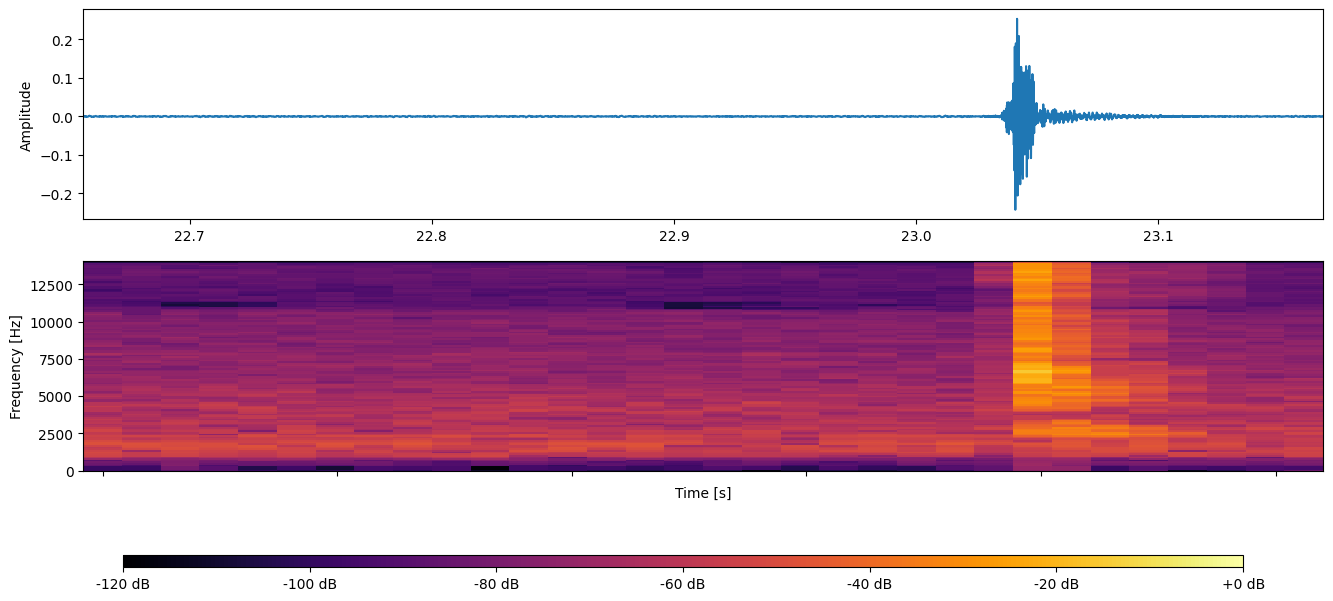

In [34]:
# check if the saved dataset can be loaded

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))
# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# plot out one spectrogram chunk
spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)